# Parte 1: Algoritmo Variacional

<div style="text-align: center;">
    <img src="img/vqc.png" alt="VQC circuit scheme">
    <p><strong>Figure 1:</strong> Variational Quantum Classifier circuit scheme.</p>
</div>


## Ejemplo 1: Clasificación entre Rocas y Cilindros Metálicos

Este es un conjunto de datos que describe los ecos de un sonar rebotando en diferentes superficies. Las 60 variables de entrada son la fuerza de los ecos en diferentes ángulos. Se trata de un problema de clasificación binaria que requiere que el modelo distinga rocas de cilindros metálicos.

Todas las variables son continuas y, en general, están en el rango de 0 a 1. La variable de salida es una cadena de texto "M" para "mina" y "R" para "roca", la cual será necesario convertir a valores enteros 1 y 0.

In [1]:
# Cargamos las librerias para Qiskit
from qiskit.circuit.library import ZZFeatureMap,RealAmplitudes
from qiskit.primitives import StatevectorSampler
from qiskit_machine_learning.optimizers import SPSA, COBYLA
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


# Manejo de los datos

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
# Leer el dataset
dataframe = pd.read_csv("data/sonar.csv", header=None)
dataset = dataframe.values

In [4]:
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [5]:
# split into input (X) and output (Y) variables
X = dataset[:,0:60].astype(float)
Y = dataset[:,60]

print(Y)

['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R'
 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R'
 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R'
 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R'
 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R'
 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M']


In [6]:
# Binarizamos los datos de salida
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
print(encoded_Y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [7]:
from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(X)
print(X)

[[0.13643068 0.15645092 0.13567674 ... 0.18535469 0.24517906 0.06004619]
 [0.32300885 0.22160309 0.27201051 ... 0.10526316 0.14049587 0.08775982]
 [0.18215339 0.24689241 0.35611038 ... 0.36842105 0.25895317 0.16628176]
 ...
 [0.37389381 0.18474068 0.05420499 ... 0.30892449 0.20936639 0.05773672]
 [0.21238938 0.14873553 0.15604468 ... 0.17391304 0.09641873 0.09699769]
 [0.18067847 0.15302186 0.03975033 ... 0.07551487 0.16528926 0.2517321 ]]


In [8]:
#Train Data
train_data, test_data, train_labels, test_labels = train_test_split(X, encoded_Y, test_size=0.2, random_state=1)
print(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape)

(166, 60) (42, 60) (166,) (42,)


# Preparando el circuito

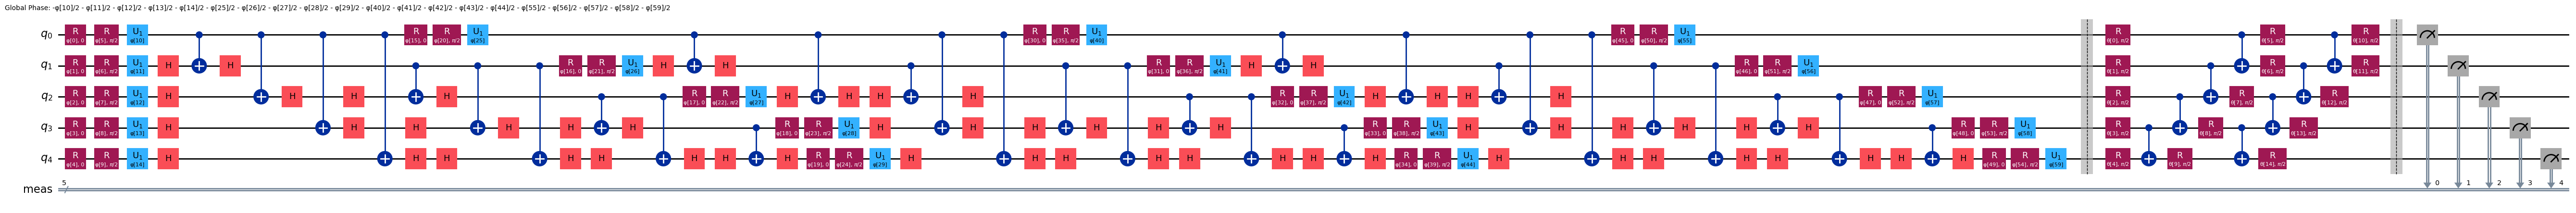

In [112]:
from qiskit.circuit.library import TwoLocal

feature_map = TwoLocal(5, ["rx","ry","rz"], "cz", parameter_prefix="φ")
feature_map.decompose().draw(output='mpl')
feature_map.barrier()
var_form = RealAmplitudes(num_qubits=5, reps=2)
circuit = feature_map.compose(var_form).decompose()
circuit.measure_all()
circuit.decompose().draw(output="mpl", fold=-1, style="iqp")

## VQC Training
Next, we will create the functions needed to tune the variational parameters from our quantum circuit. First, we will assign the data to the parameters of the feature map, then we will update $\tilde{\theta}$ in the variational circuit with the optimization algorithm.

In [113]:
def circuit_instance(data, variational):
    """
    Assigns parameter values to the quantum circuit.
    """
    parameters = {}
    for i, p in enumerate(feature_map.parameters):
        parameters[p] = data[i]
    for i, p in enumerate(var_form.ordered_parameters):
        parameters[p] = variational[i]
    return circuit.assign_parameters(parameters)


We need to translate the predictions obtained with the quantum circuit into probabilities. To achieve this, we evaluate the parity from the bitstrings and calculate their probability of occurrence given the number of shots from the execution. 

In [114]:
def labels_probability(results):
    """
    Converts a dictionary of bitstrings and their counts, to parities and their counts
    """
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = (sum(int(k) for k in list(bitstring))+1) % 2
        probabilities[label] += counts / shots
    return probabilities

In [115]:
def classification_probability_simulation(data, variational):
    """
    Classify data points using given parameters.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    sampler = StatevectorSampler()
    results = sampler.run(circuits).result()
    # print(results[1].data.meas.get_counts())
    classification = [labels_probability(results[i].data.meas.get_counts()) for i, c in enumerate(circuits)]
    return classification

In [116]:
def cross_entropy_loss(classification, expected):
    """
    Calculate accuracy of predictions using cross entropy loss.
    """
    p = classification.get(expected)  
    return -np.log(p + 1e-10)

In [117]:
def cost_function(data, labels, variational):
    """
    Evaluates performance of our circuit with variational parameters on data.
    """
    classifications = classification_probability_simulation(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost

In [118]:
def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(train_data, train_labels, variational)


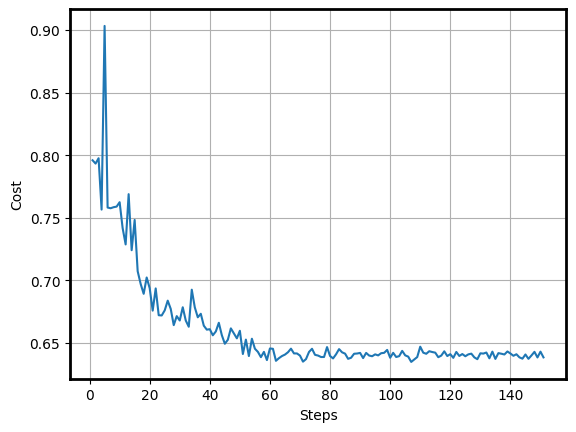

In [119]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)
             
# Set up the optimization
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
        self.evaluation_count = 0

    def update(self, parameter):
        """Save intermediate results. COBYLA passes only the parameter vector."""
        self.evaluation_count += 1
        cost = objective_function(parameter)
        self.evaluations.append(self.evaluation_count)
        self.parameters.append(parameter)
        self.costs.append(cost)


log = OptimizerLog()

optimizer = COBYLA(maxiter=150, callback=log.update)

initial_point = np.zeros((var_form.num_parameters))

# Run the optimization
result = optimizer.minimize(objective_function, initial_point)

opt_var = result.x
opt_value = result.fun

fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.grid(True)
plt.rc('axes', linewidth=2)  # Set the axes linewidth globally
ax = plt.gca()  # Get current axes
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
plt.show()

In [120]:
def create_conf_mat(y_true, y_pred, title):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix by row (i.e., by the number of samples in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create a custom colormap
    colors = [(1, 1, 1), (0/255, 255/255, 0/255)] 
    n_bins = 100  # Number of bins in the colormap
    cmap_name = 'custom_blue'
    custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    # Display confusion matrix
    fig, ax = plt.subplots()
    cax = ax.matshow(cm_normalized, cmap=custom_cmap)

    # Add color bar
    fig.colorbar(cax)

    # Set predefined RGB color for the text
    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            color = 'white' if i == j else 'black'
            ax.text(j, i, f'{cm_normalized[i, j]:.1f}%', va='center', ha='center', color=color)

    # Set predefined background color for the diagonal elements (e.g., RGB (255, 255, 0))
    diagonal_color = (98/255, 35/255, 223/255)  # Normalize to 0-1 range
    for i in range(cm_normalized.shape[0]):
        ax.add_patch(plt.Rectangle((i-0.5, i-0.5), 1, 1, fill=True, color=diagonal_color, alpha=0.3))

    # Set predefined background color for the plot (e.g., RGB (240, 240, 240))
    background_color = (1, 1, 1)  # Normalize to 0-1 range
    fig.patch.set_facecolor(background_color)
    ax.set_facecolor(background_color)

    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

Simulated Test Accuracy: 64.29%


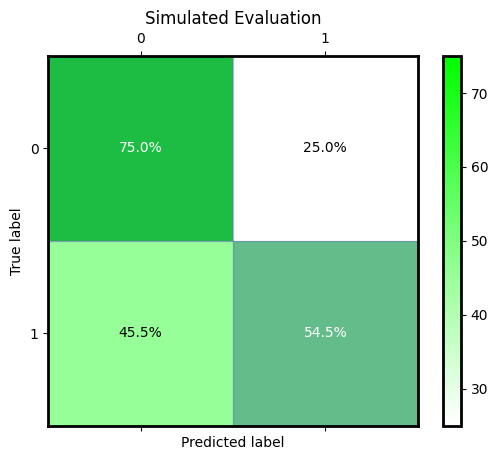

In [121]:
# Packages for data visualization
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def test_classifier(data, labels, variational):
    """
    Gets classifier'spredictions and calculates accuracy 
    """
    probability = classification_probability_simulation(data, variational)
    predictions = [0 if p[0] >= p[1] else 1 for p in probability]
    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    print(f"Simulated Test Accuracy: {accuracy * 100:.2f}%")
    create_conf_mat(labels, predictions, "Simulated Evaluation")
    return accuracy, predictions

accuracy_sim, predictions_sim = test_classifier(test_data, test_labels, opt_var)

# Diferente Mapa de Caractersiticas

# Preparando el circuito

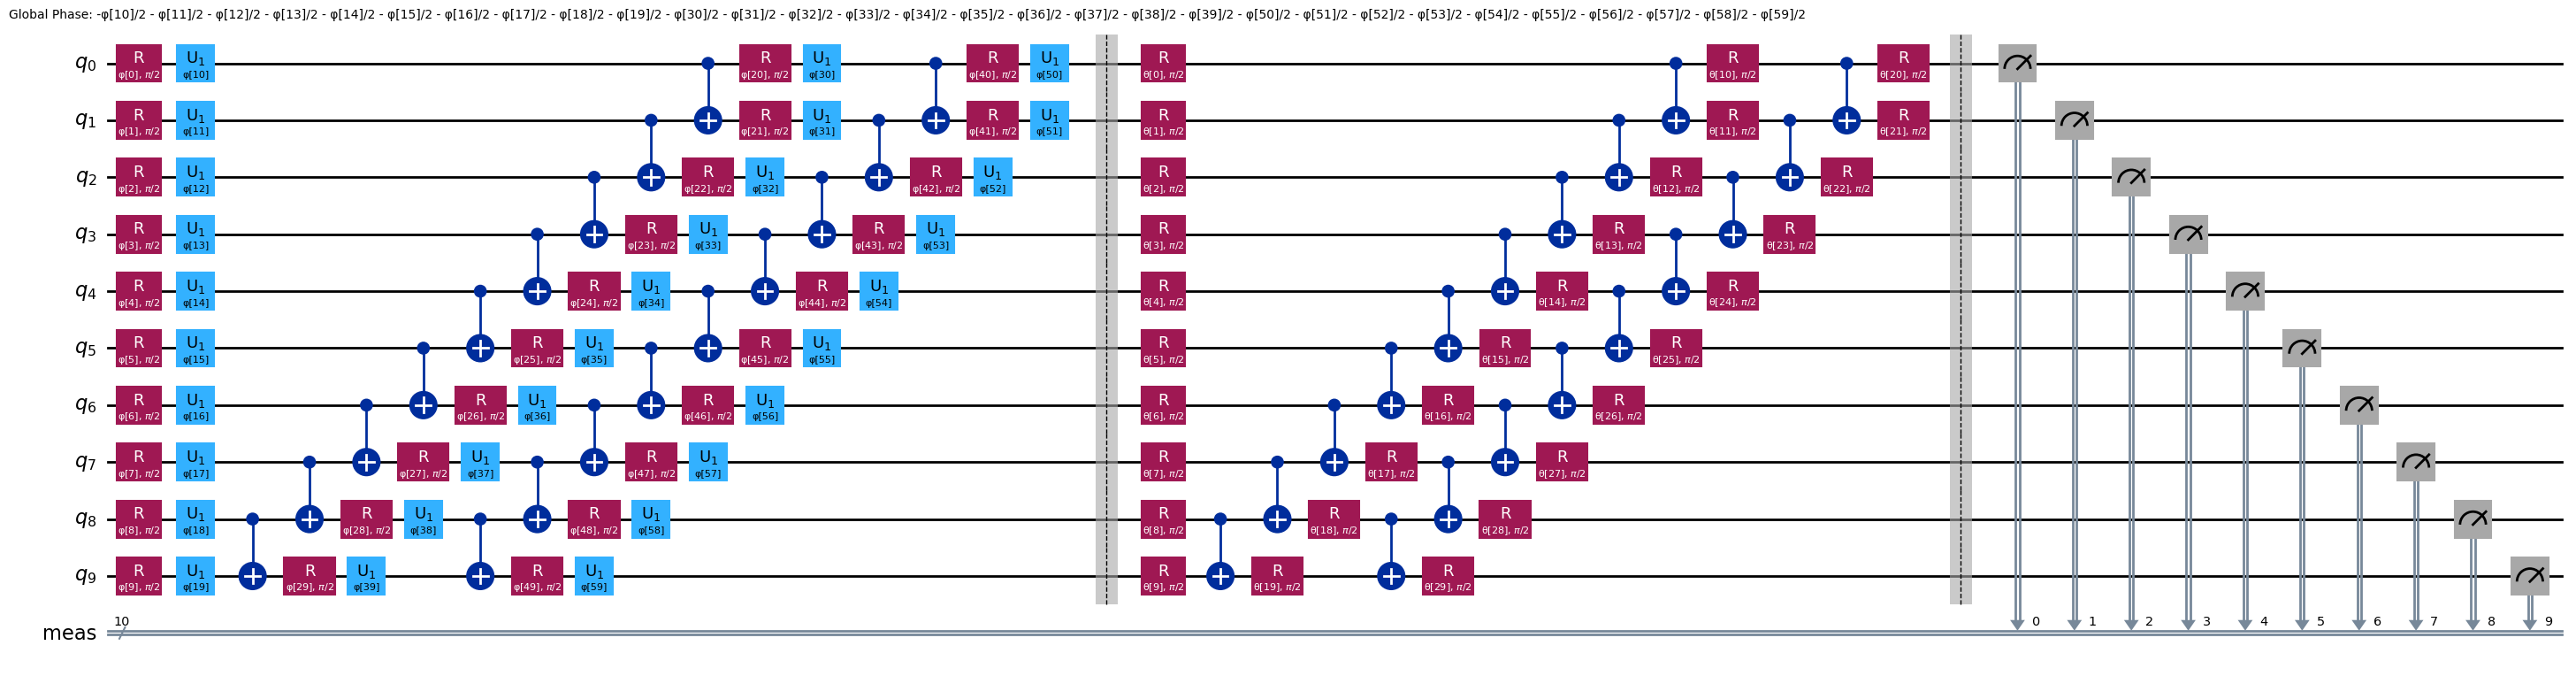

In [132]:
from qiskit.circuit.library import TwoLocal, EfficientSU2
num_features = 60
feature_map = EfficientSU2(num_qubits=num_features//6, reps=2, parameter_prefix="φ")
feature_map.decompose().draw(output='mpl')
feature_map.barrier()
var_form = RealAmplitudes(num_qubits=num_features//6, reps=2)
circuit = feature_map.compose(var_form).decompose()
circuit.measure_all()
circuit.decompose().draw(output="mpl", fold=-1, style="iqp")

## VQC Training
Next, we will create the functions needed to tune the variational parameters from our quantum circuit. First, we will assign the data to the parameters of the feature map, then we will update $\tilde{\theta}$ in the variational circuit with the optimization algorithm.

In [133]:
def circuit_instance(data, variational):
    """
    Assigns parameter values to the quantum circuit.
    """
    parameters = {}
    for i, p in enumerate(feature_map.parameters):
        parameters[p] = data[i]
    for i, p in enumerate(var_form.ordered_parameters):
        parameters[p] = variational[i]
    return circuit.assign_parameters(parameters)


We need to translate the predictions obtained with the quantum circuit into probabilities. To achieve this, we evaluate the parity from the bitstrings and calculate their probability of occurrence given the number of shots from the execution. 

In [134]:
def labels_probability(results):
    """
    Converts a dictionary of bitstrings and their counts, to parities and their counts
    """
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = (sum(int(k) for k in list(bitstring))+1) % 2
        probabilities[label] += counts / shots
    return probabilities

In [135]:
def classification_probability_simulation(data, variational):
    """
    Classify data points using given parameters.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    sampler = StatevectorSampler()
    results = sampler.run(circuits).result()
    # print(results[1].data.meas.get_counts())
    classification = [labels_probability(results[i].data.meas.get_counts()) for i, c in enumerate(circuits)]
    return classification

In [136]:
def cross_entropy_loss(classification, expected):
    """
    Calculate accuracy of predictions using cross entropy loss.
    """
    p = classification.get(expected)  
    return -np.log(p + 1e-10)

In [137]:
def cost_function(data, labels, variational):
    """
    Evaluates performance of our circuit with variational parameters on data.
    """
    classifications = classification_probability_simulation(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost

In [138]:
def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(train_data, train_labels, variational)


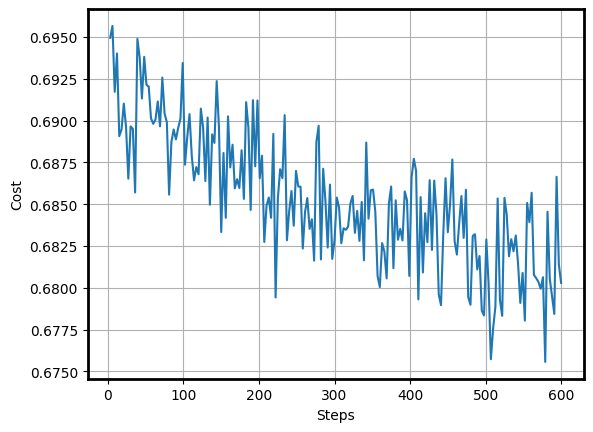

In [139]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)
             
# Set up the optimization
# class OptimizerLog:
#     """Log to store optimizer's intermediate results"""
#     def __init__(self):
#         self.evaluations = []
#         self.parameters = []
#         self.costs = []
#         self.evaluation_count = 0

#     def update(self, parameter):
#         """Save intermediate results. COBYLA passes only the parameter vector."""
#         self.evaluation_count += 1
#         cost = objective_function(parameter)
#         self.evaluations.append(self.evaluation_count)
#         self.parameters.append(parameter)
#         self.costs.append(cost)


log = OptimizerLog()

optimizer = SPSA(maxiter=200, callback=log.update)

initial_point = np.zeros((var_form.num_parameters))

# Run the optimization
result = optimizer.minimize(objective_function, initial_point)

opt_var = result.x
opt_value = result.fun

fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.grid(True)
plt.rc('axes', linewidth=2)  # Set the axes linewidth globally
ax = plt.gca()  # Get current axes
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
plt.show()

In [140]:
def create_conf_mat(y_true, y_pred, title):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix by row (i.e., by the number of samples in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create a custom colormap
    colors = [(1, 1, 1), (0/255, 255/255, 0/255)] 
    n_bins = 100  # Number of bins in the colormap
    cmap_name = 'custom_blue'
    custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    # Display confusion matrix
    fig, ax = plt.subplots()
    cax = ax.matshow(cm_normalized, cmap=custom_cmap)

    # Add color bar
    fig.colorbar(cax)

    # Set predefined RGB color for the text
    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            color = 'white' if i == j else 'black'
            ax.text(j, i, f'{cm_normalized[i, j]:.1f}%', va='center', ha='center', color=color)

    # Set predefined background color for the diagonal elements (e.g., RGB (255, 255, 0))
    diagonal_color = (98/255, 35/255, 223/255)  # Normalize to 0-1 range
    for i in range(cm_normalized.shape[0]):
        ax.add_patch(plt.Rectangle((i-0.5, i-0.5), 1, 1, fill=True, color=diagonal_color, alpha=0.3))

    # Set predefined background color for the plot (e.g., RGB (240, 240, 240))
    background_color = (1, 1, 1)  # Normalize to 0-1 range
    fig.patch.set_facecolor(background_color)
    ax.set_facecolor(background_color)

    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

Simulated Test Accuracy: 50.00%


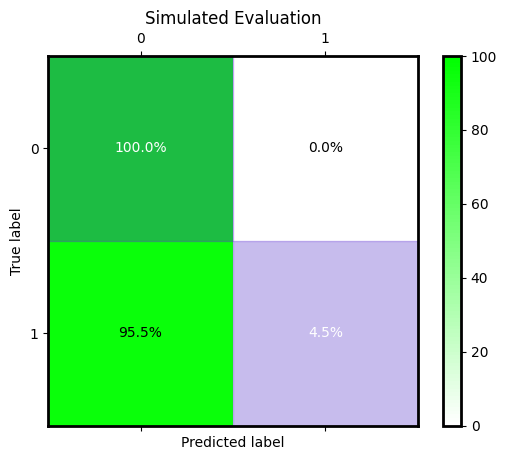

In [141]:
# Packages for data visualization
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def test_classifier(data, labels, variational):
    """
    Gets classifier'spredictions and calculates accuracy 
    """
    probability = classification_probability_simulation(data, variational)
    predictions = [0 if p[0] >= p[1] else 1 for p in probability]
    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    print(f"Simulated Test Accuracy: {accuracy * 100:.2f}%")
    create_conf_mat(labels, predictions, "Simulated Evaluation")
    return accuracy, predictions

accuracy_sim, predictions_sim = test_classifier(test_data, test_labels, opt_var)